In [12]:
import pandas as pd

# 读取数据
df = pd.read_csv('weibo_after_fe.csv', encoding='utf-8-sig')
print(f"数据: {len(df)} 行，{len(df.columns)} 列")

数据: 358584 行，18 列


### 划分数据集

In [13]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["sentiment_polarity"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

len(X_train), len(X_val), len(X_test)

(251008, 53788, 53788)

在后续的实验中仍会使用到未经分词、词元化的原始文本表示的数据进行训练，因此这里将划分好的原始数据集保存到本地。

另外，后续训练模型时还会发现，反向传播时使用的损失函数（`NLLLoss` 或 `CrossEntropyLoss`）要求样本的标签为 `0 ~num_classes-1` 之间的整数，因此需要将情感标签从原始的 `[-1, 0, 1]` 映射到 `[0, 1, 2]`。

这里使用函数 `remap_labels` 来实现标签的映射。

In [23]:
import os
from pandas import DataFrame

def remap_labels(data: DataFrame, label_mapping={-1:0, 0:1, 1:2}):  #@save
    remapped_data = []
    for tokens, old_label in data.values:
        new_label = label_mapping.get(old_label, old_label)
        remapped_data.append((tokens, new_label))
    return pd.DataFrame(remapped_data, columns=[0, 1])


train_raw = remap_labels(DataFrame({0: X_train, 1: y_train}))
val_raw = remap_labels(DataFrame({0: X_val, 1: y_val}))
test_raw = remap_labels(DataFrame({0: X_test, 1: y_test}))


def save_data(data: DataFrame, file_path: str, sep: str = ''):  #@save
    if os.path.exists(file_path):
        print(f"{file_path} 已存在，跳过保存。")
        return
    with open(file_path, 'w', encoding='utf-8') as f:
        for X, y in data.values:
            if not sep:
                f.write(f"{X}:{y}\n")
            else:
                f.write(f"{sep.join(X)}:{y}\n")
    print(f"已保存到 {file_path}。")

save_data(train_raw, 'train_raw.txt')
save_data(val_raw, 'val_raw.txt')
save_data(test_raw, 'test_raw.txt')

train_raw.txt 已存在，跳过保存。
val_raw.txt 已存在，跳过保存。
test_raw.txt 已存在，跳过保存。


In [15]:
def segment_data(X, y, file_path='', batch_size=1000):
    """
    分批处理数据以避免内存不足问题
    batch_size: 每批处理的数据量，默认1000条
    """
    if os.path.exists(file_path):
        print(f"文件 {file_path} 已存在，跳过处理。")
        return
    if not isinstance(X, list):
        X = X.tolist()
    if not isinstance(y, list):
        y = y.tolist()
    
    from ltp import LTP
    ltp = LTP()
    
    print(f"开始处理 {len(X)} 条数据，批大小: {batch_size}")
    
    if len(file_path) > 0:
        # 打开文件准备写入
        with open(file_path, 'w', encoding='utf-8') as f:
            # 分批处理
            for i in range(0, len(X), batch_size):
                batch_end = min(i + batch_size, len(X))
                batch_X = X[i:batch_end]
                batch_y = y[i:batch_end]
                
                print(f"正在处理第 {i//batch_size + 1} 批，数据范围: {i}-{batch_end-1}")
                
                # 对当前批次进行分词
                segment = ltp.pipeline(batch_X, tasks=['cws'], return_dict=False)[0]
                
                # 写入文件
                for sublist, label in zip(segment, batch_y):
                    f.write('<sp>'.join(sublist) + ':' + str(label) + '\n')
                
                print(f"第 {i//batch_size + 1} 批处理完成")
    
    print("所有数据处理完成！")

# 分批处理数据，使用较小的批大小以避免内存问题
print("开始处理训练集...")
segment_data(X_train, y_train, 'train_segmented.txt', batch_size=500)

print("\n开始处理验证集...")
segment_data(X_val, y_val, 'val_segmented.txt', batch_size=500)

print("\n开始处理测试集...")
segment_data(X_test, y_test, 'test_segmented.txt', batch_size=500)

开始处理训练集...
文件 train_segmented.txt 已存在，跳过处理。

开始处理验证集...
文件 val_segmented.txt 已存在，跳过处理。

开始处理测试集...
文件 test_segmented.txt 已存在，跳过处理。


In [21]:
from pandas import Series, DataFrame

def load_data(  #@save
        file_path: str, 
        sep='', 
        is_segmented=False, 
        is_vectorized=False) -> DataFrame:
    data = []
    with open(file_path, 'r', encoding='utf-8-sig') as f:
        for line in f:
            X, y = line.rsplit(':', 1)
            if is_segmented:
                X = [token.strip() for token in X.split(sep) if token.strip() != '']
            elif is_vectorized:
                X = list(map(int, X.split(sep)))
            y = int(float(y))
            data.append((X, y))
    return DataFrame(data, columns=[0, 1])


train_seg = load_data('train_segmented.txt', sep='<sp>', is_segmented=True)
val_seg = load_data('val_segmented.txt', sep='<sp>', is_segmented=True)
test_seg = load_data('test_segmented.txt', sep='<sp>', is_segmented=True)

为保持统一，这里将分词完毕的数据集也使用同样的函数进行标签映射，然后再次保存。

In [25]:
train_seg = remap_labels(train_seg)
val_seg = remap_labels(val_seg)
test_seg = remap_labels(test_seg)

save_data(train_seg, 'train_segmented.txt', sep='<sp>')
save_data(val_seg, 'val_segmented.txt', sep='<sp>')
save_data(test_seg, 'test_segmented.txt', sep='<sp>')

已保存到 train_segmented.txt。
已保存到 val_segmented.txt。
已保存到 test_segmented.txt。


仅使用训练集的数据构建词表 `vocab`：

事先统计训练集中所有词元的词频，用于确认构建词表 `vocab` 的最小词频 `min_freq` 参数。

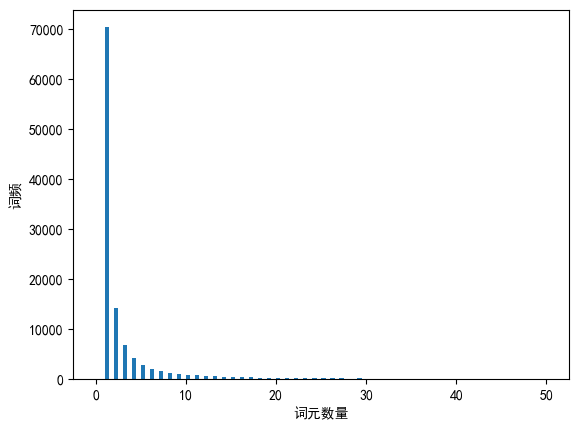

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

token_counts = Counter(token for sentence in train_seg[0] for token in sentence)
freqs = list(token_counts.values())
plt.hist(freqs, bins=100, range=(0,50))
plt.xlabel('词元数量')
plt.ylabel('词频')
plt.show();

查看频率最高的前50个词元：

In [7]:
token_counts.most_common(50)

[('的', 135301),
 ('了', 102177),
 ('，', 94444),
 ('我', 83264),
 ('是', 42966),
 ('不', 42016),
 ('！', 40245),
 ('。', 39353),
 ('一', 34997),
 ('啊', 32060),
 ('好', 31510),
 ('就', 22331),
 ('都', 21457),
 ('在', 20263),
 ('想', 18825),
 ('有', 16289),
 ('你', 16257),
 ('要', 16117),
 ('人', 15489),
 ('吃', 15435),
 ('到', 15056),
 ('天', 14702),
 ('也', 14045),
 ('个', 13556),
 ('这', 13390),
 ('又', 13235),
 ('看', 13114),
 ('能', 12838),
 ('很', 12504),
 ('没', 11899),
 ('会', 11117),
 ('和', 10988),
 ('真', 10893),
 ('今天', 10700),
 ('小', 10588),
 ('去', 10306),
 ('还', 10280),
 ('太', 10242),
 ('自己', 10192),
 ('上', 9963),
 ('一个', 9788),
 ('来', 9417),
 ('着', 8204),
 ('给', 7893),
 ('多', 7774),
 ('？', 7385),
 ('得', 7369),
 ('这个', 7309),
 ('说', 7119),
 ('爱', 7088)]

分析：
- 出现标点符号：如 `，`、`。`、`！` 等
    - 对于分句作用的符号，如 `，`、`。`、`、` 等，对于情感表达的作用不大，可以考虑去除。
    - 对于表示情感的符号，如 `！`、`？` 等，可以考虑保留。
- 出现虚词，如 `的`、`了`、`在`
    - 尽管此类词语在语义上作用不大，但：
        - 对传统机器学习来说，可通过权重自动弱化
        - 对深度模型来说，它们的词嵌入会自动学到较弱权重
    - 因此考虑保留此类词语

查看词元计数器中出现的所有标点符号：

In [8]:
import unicodedata

punct_tokens = [
    (t, freq) for t, freq in token_counts.items() 
    if all(unicodedata.category(ch).startswith('P') 
           for ch in t)]

punct_tokens

[('。', 39353),
 ('，', 94444),
 ('！', 40245),
 ('？', 7385),
 ('：', 5335),
 ('（', 4354),
 ('）', 3252),
 ('(', 2655),
 (')', 2628),
 ('【', 493),
 ('】', 469),
 ('；', 169),
 ('_', 289),
 ('"', 206),
 ('__', 4),
 ('___', 8),
 ('_____', 1),
 ('___________', 1),
 ('_______', 2),
 ('____________', 1),
 ('____', 4),
 ('__________', 1),
 ('（）', 1),
 ('________', 1)]

对标点符号的进一步分类与分析：
- 表示情感的符号：如 `！`、`？` 等，保留

- 分句符号：如 `，`、`。`、`；` 等，去除

- 结构性符号：如 `（`、`）`、`【`、`】` 等，去除

- 异常符号（人工添加线）：如 `_`、`__` 等，去除

In [9]:
def clean_punct(data: DataFrame) -> DataFrame:
    """
    清理数据集中所有句子中的标点符号
    保留表示情感的符号，去除其他标点符号
    """
    remove_punct = {'，', '。', '；', '：', '"', '（', '）', '【', '】', '_'}
    cleaned_data = []
    
    # 直接操作数据，避免重复创建DataFrame
    for tokens, label in data.values:
        cleaned_sentence = [token for token in tokens if token not in remove_punct]
        if len(cleaned_sentence) > 3:
            cleaned_data.append([cleaned_sentence, label])
    
    # 一次性创建DataFrame
    return pd.DataFrame(cleaned_data, columns=[0, 1])


train_clean = clean_punct(train_seg)
val_clean = clean_punct(val_seg)
test_clean = clean_punct(test_seg)

len(train_clean), len(val_clean), len(test_clean)

(228943, 49029, 49057)

构建词表参数 `min_freq` 的设置分析：统计覆盖率

In [10]:
from collections import Counter

token_counts = Counter(token for sentence in train_clean[0] for token in sentence)
total_tokens = sum(token_counts.values())

for mf in [1, 2, 3, 5, 10]:
    kept_tokens = sum(count for count in token_counts.values() if count >= mf)
    print(f"min_freq: {mf}\tcoverage: {kept_tokens / total_tokens}")

min_freq: 1	coverage: 1.0
min_freq: 2	coverage: 0.9760733394093619
min_freq: 3	coverage: 0.9663109196698582
min_freq: 5	coverage: 0.9536032287327804
min_freq: 10	coverage: 0.9328601195926468


构建词表，设置最小词频 `min_freq=3`，即词频小于3的词元将被视为 `<UNK>` 词元。

In [11]:
from collections import defaultdict

class Vocab:
    def __init__(self, tokens=None) -> None:
        self.idx_to_token = list()
        self.token_to_idx = dict()

        if tokens is not None:
            if "<unk>" not in tokens:
                tokens = tokens + ["<unk"]
            for token in tokens:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
            self.unk = self.token_to_idx["<unk>"]

    @classmethod
    def build(cls, text, min_freq=1, reserved_tokens=None):
        token_freqs = defaultdict(int)
        for sentence in text:
            for token in sentence:
                token_freqs[token] += 1
        
        uniq_tokens = ["<unk>"] + (reserved_tokens if reserved_tokens else [])
        uniq_tokens += [token for token, freq in token_freqs.items() 
                        if freq >= min_freq and token != "<unk>"]
        return cls(uniq_tokens)

    def __len__(self) -> int:
        return len(self.idx_to_token)
    
    def __getitem__(self, token):
        """查找输入词元对应的索引值，若不存在，则返回<unk>的索引值（0）"""
        return self.token_to_idx.get(token, self.unk)
    
    def convert_tokens_to_ids(self, tokens):
        """查找一系列输入词元的索引值"""
        return [self[token] for token in tokens]
    
    def convert_ids_to_tokens(self, indices):
        """查找一系列输入索引值对应的词元"""
        return [self.idx_to_token[index] for index in indices]

def save_vocab(vocab: Vocab, file_path: str):
    with open(file_path, 'w', encoding='utf-8-sig') as f:
        f.write('\n'.join(vocab.idx_to_token))

def read_vocab(file_path: str) -> Vocab:
    with open(file_path, 'r', encoding='utf-8-sig') as f:
        tokens = f.read().split('\n')
    return Vocab(tokens)

vocab = Vocab.build(train_clean[0], min_freq=3)

In [12]:
len(vocab)

33152

In [ ]:
train_idx = DataFrame([
    [vocab.convert_tokens_to_ids(sentence), label]
    for sentence, label in train_clean.values
])
val_idx = DataFrame([
    [vocab.convert_tokens_to_ids(sentence), label]
    for sentence, label in val_clean.values
])
test_idx = DataFrame([
    [vocab.convert_tokens_to_ids(sentence), label]
    for sentence, label in test_clean.values
])

同样地，需要将情感标签从原始的 `[-1, 0, 1]` 映射到 `[0, 1, 2]`。

In [ ]:
train_data = remap_labels(train_idx)
val_data = remap_labels(val_idx)
test_data = remap_labels(test_idx)

将数据集保存至本地

In [ ]:
save_data(train_data, 'train_indexed.txt', sep=',')
save_data(val_data, 'val_indexed.txt', sep=',')
save_data(test_data, 'test_indexed.txt', sep=',')

save_vocab(vocab, 'vocab.txt')